## Book preferences
##### In this notebook we´ll work with a **classification problem** to determine if a reader will like a book, based on their previous preference.

##### We´ll work with 3 dataset we´ll need to join:
 - Books: Gathering book information such as: Title, Author, Genre, Editorial, Edition Year, ISBN number, summary and cover image.
 - Readers: Gathering reader information such as: Name, Sex, Age, Nationality 
 - Preference: Our main dataset. It only has information about the reader (id_lector), the book they read (id_libro), and a label indicating if they liked it (1) or not (0)

##### The datasets for this notebook come from [Que libro leo site](https://quelibroleo.com), a social catalogin web site used by book lovers to find, track, and review books. 

#### The datasets can be downloaded from: 

### Library Loading

In [1]:
import pandas as pd
import sklearn as sk
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Auxiliary NaN-counter function

In [2]:
# A simple function to count NaN values across columns so we can keep track of them
def nulos(df):
      NaN_list=[]
      Not_Nan_list=[]

      for c in df.columns:
            NaN_list.append(df[c].isna().sum())
            Not_Nan_list.append(df[c].notna().sum())

      NaN_df=pd.DataFrame(
      {"Nan":NaN_list,
      "Not NaN": Not_Nan_list},
      index=df.columns 
      )
      return NaN_df

### Data Loading

In [3]:
books=pd.read_csv(r"D:\Documentos\BACK UP RED INBIRS. 20221011\Doctorado\Cursos\Data Mining\1er año\DM\Libros\libros.csv", index_col="id_libro")
readers=pd.read_csv(r"D:\Documentos\BACK UP RED INBIRS. 20221011\Doctorado\Cursos\Data Mining\1er año\DM\Libros\lectores.csv", index_col="id_lector")
preference=pd.read_csv(r"D:\Documentos\BACK UP RED INBIRS. 20221011\Doctorado\Cursos\Data Mining\1er año\DM\Libros\entrenamiento.csv", index_col="id_lector")

### Understanding and cleaning the data

#### Books DataFrame

In [4]:
books.head()

,titulo,autor,genero,editorial,anio_edicion,isbn,resumen,img_src
id_libro,,,,,,,,
las-particulas-elementales,LAS PARTÍCULAS ELEMENTALES,"HOUELLEBECQ, MICHEL",Narrativa,ANAGRAMA,2006,9788433967305,"En Las partículas elementales, Houellebecq lle...",https://quelibroleo.com/images/libros/libro-15...
quien-domina-el-mundo,¿QUIÉN DOMINA EL MUNDO?,"CHOMSKY, NOAM",Ensayo,EDICIONES B,2016,9788466659888,"¿Quién domina el mundo?, encarnizado, implacab...",https://quelibroleo.com/images/libros/libro-14...
antimanual-de-filosofia,ANTIMANUAL DE FILOSOFÍA,"ONFRAY, MICHEL",Ensayo,EDAF,2011,9788441414259,NaN,https://quelibroleo.com/images/libros/libro_12...
momentos-estelares-de-la-humanidad-catorce-miniaturas-historicas,MOMENTOS ESTELARES DE LA HUMANIDAD: Catorce Mi...,"ZWEIG, STEFAN",Histórica y aventuras,ACANTILADO,2002,9788495359926,Éste es probablemente el libro más famoso de S...,https://quelibroleo.com/images/libros/libro_13...
la-invencion-del-pasado,LA INVENCIÓN DEL PASADO,"MURADO, MIGUEL-ANXO",Lecturas complementarias,DEBATE,2013,9788483068533,NaN,https://quelibroleo.com/images/libros/C848533.jpg


In [5]:
#Examine books data set
books.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24312 entries, las-particulas-elementales to el-secreto-de-tedd-y-todd
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   titulo        24267 non-null  object
 1   autor         24267 non-null  object
 2   genero        24267 non-null  object
 3   editorial     24259 non-null  object
 4   anio_edicion  24230 non-null  object
 5   isbn          24140 non-null  object
 6   resumen       16200 non-null  object
 7   img_src       24312 non-null  object
dtypes: object(8)
memory usage: 1.7+ MB


In [6]:
books.shape

(24312, 8)

Removing duplicates

In [7]:
# Find duplicates based on the index
duplicates = books.index.duplicated(keep='first')
# Invert the boolean mask to keep only non-duplicate rows
non_duplicate_rows = ~duplicates
# Filter the DataFrame to keep only non-duplicate rows
books= books[non_duplicate_rows]

books.shape

(24306, 8)

Removing unnecessary columns 

In [8]:
books.drop(["isbn", "resumen", "img_src"], axis="columns", inplace=True)

Genre Cleaning

In [9]:
#Which books gender are in the dataset?
genre =books.groupby("genero")
lista_generos = list(genre.groups.keys())
lista_generos

['Actores',
 'Administración y dirección empresarial',
 'Arte',
 'Astrología y  horóscopos',
 'Autoayuda',
 'Autoayuda Y Espiritualidad',
 'Biografiás, Memorias',
 'Biografías',
 'Biografías, Memorias',
 'Ciencia ficción en bolsillo',
 'Ciencias',
 'Ciencias Humanas',
 'Ciencias Políticas Y Sociales',
 'Clasicos de la literatura',
 'Clásicos de la literatura',
 'Cocina',
 'Cómics',
 'Cómics de humor',
 'Cómics, Novela Gráfica',
 'Deportes Y Juegos',
 'Deportes sobre ruedas',
 'Derecho',
 'Didáctica y metodología',
 'Dietética y nutrición',
 'Economía',
 'Economía financiera',
 'Empresa',
 'Ensayo',
 'Estudios y ensayos',
 'Fantástica, ciencia ficción',
 'Ficción literaria',
 'Filología',
 'Fotografía',
 'Guías De Viaje',
 'Historia',
 'Historia del cine',
 'Historia moderna de España',
 'Histórica',
 'Histórica Y Aventuras',
 'Histórica y aventuras',
 'Humor',
 'Idiomas',
 'Infantil y juvenil',
 'Informática',
 'Juvenil',
 'Lecturas complementarias',
 'Literatura contemporánea',
 'Mate

Since there are a lot of genres and several ones that appear more than once with different name, we are going to reduce its number

In [10]:
genre_mapping = {
    'Álbumes ilustrados': 'Infantil',
    "Actores": 'Actores',
    'Administración y dirección empresarial': 'Empresa',
    'Arte': 'Arte',
    'Astrología y  horóscopos': 'Varios',
    'Autoayuda': 'Autoayuda',
    'Autoayuda Y Espiritualidad': 'Autoayuda',
    'Biografiás, Memorias': 'Biografías',
    'Biografías': 'Biografías',
    'Ciencia ficción en bolsillo': 'Ciencia ficción',
    'Ciencias': 'Ciencias',
    'Ciencias Humanas': 'Ciencias humanas',
    'Ciencias Políticas Y Sociales': 'Ciencias humanas',
    'Clasicos de la literatura': 'Clásicos de la literatura',
    'Clásicos de la literatura': 'Clásicos de la literatura',
    'Cocina': 'Cocina',
    'Cómics': 'Cómics',
    'Cómics de humor': 'Cómics',
    'Cómics, Novela Gráfica': 'Cómics',
    'Deportes Y Juegos': 'Deportes',
    'Deportes sobre ruedas': 'Deportes',
    'Derecho': 'Derecho',
    'Didáctica y metodología': 'Didáctica y metodología',
    'Dietética y nutrición': 'Dietética y nutrición',
    'Economía': 'Economía',
    'Economía financiera': 'Economía',
    'Empresa': 'Empresa',
    'Ensayo': 'Ensayo',
    'Estudios y ensayos': 'Ensayo',
    'Fantástica, ciencia ficción': 'Ciencia ficción',
    'Ficción literaria': 'Ficción literaria',
    'Filología': 'Ciencias humanas',
    'Fotografía': 'Fotografía',
    'Guías De Viaje': 'Guías De Viaje',
    'Historia': 'Historia',
    'Historia del cine': 'Historia',
    'Historia moderna de España': 'Historia',
    'Histórica': 'Historia',
    'Histórica Y Aventuras': 'Histórica y Aventuras',
    'histórica y aventuras': 'Histórica y Aventuras',
    'Humor': 'Humor',
    'Idiomas': 'Idiomas',
    'Infantil y juvenil': 'Infantil',
    'Informática': 'Ciencia',
    'Juvenil': 'Juvenil',
    'Lecturas complementarias': 'Varios',
    'Literatura contemporánea': 'Literatura contemporánea',
    'Matemáticas divulgativas': 'Ciencias',
    'Medicina': 'Ciencia',
    'Medicina divulgativa': 'Ciencia',
    'Música': 'Música',
    'Narrativa': 'Narrativa',
    'Narrativa histórica': 'Narrativa',
    'Naturaleza y ciencia': 'Ciencia',
    'No Ficción': 'No ficción',
    'No ficción': 'No ficción',
    'Novela': 'Novela',
    'Novela Negra, Intriga, Terror': 'Novela Negra',
    'Novela negra': 'Novela negra',
    'Novela negra, intriga, terror': 'Novela negra',
    'Poesía': 'Poesía, Teatro',
    'Poesía, Teatro': 'Poesía, Teatro',
    'Poesía, teatro': 'Poesía, Teatro',
    'Policiaca. Novela negra en bolsillo': 'Policial',
    'Política nacional': 'Ciencias humanas',
    'Psicología Y Pedagogía': 'Ciencias humanas',
    'Romántica': 'Romántica',
    'Romántica, Erótica': 'Romántica',
    'Romántica, erótica': 'Romántica',
    'Televisión': 'Televisión',
    'Varios': 'Varios',
    'varios': 'Varios', 
}


books['genero'] = books['genero'].map(genre_mapping).fillna(books['genero'])

#### Web Scrapping

An intereseting feature we can add to this dataset is the mean calification each book has, based on all the readers from [Que libro leo site](https://quelibroleo.com).
The following chunk includes the code for scrapping and adds the man calification. It can take long (it took me 12 hours). If you want to skip this part you can directly load the csv file with the mean calification added on the next chunk.

In [11]:
'''
#Mean calification web scrapping

import requests
from bs4 import BeautifulSoup
import time

# Which site are we scrapping from
base_url = 'https://quelibroleo.com/search/'

def get_mean_calification(book_title):
    encoded_title = urllib.parse.quote(book_title)  # Encode spaces as %20
    search_url = base_url + encoded_title
    response = requests.get(search_url)

    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        # Find the div with class "estadisticas"
        estadisticas_div = soup.find('div', class_='estadisticas')
        if estadisticas_div:
            # Find the span containing the mean calification
            mean_calification_span = estadisticas_div.find('span')
            if mean_calification_span:
                # Extract the mean calification value
                mean_calification_text = mean_calification_span.get_text(strip=True)
                # Handle case where mean calification is not available ('-')
                if mean_calification_text == '-':
                    return None
                try:
                    # Attempt to convert the numeric part to float
                    mean_calification = float(mean_calification_text.replace(',', '.'))
                    return mean_calification
                except ValueError:
                    # Handle cases where conversion fails (e.g., unexpected format)
                    return None
    return None

# Iterate over each book title in the DataFrame
mean_califications = []
for title in df_libros['titulo']:
    mean_calification = get_mean_calification(title)
    if mean_calification:
        mean_califications.append(mean_calification)
    else:
        mean_rcalifications.append(None)

# Add mean_califications to books DataFrame
df_libros['mean_calification'] = mean_califications

#Export books dataframe with mean calification added

version = "books_calification"
import os

directory = r"D:\yourdirectory"

# Save CSV file
books.to_csv(fr"{directory}/{version}.csv", index=True)

'''

<>:1: SyntaxWarning: invalid escape sequence '\y'
<>:1: SyntaxWarning: invalid escape sequence '\y'
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_26288\1557933236.py:1: SyntaxWarning: invalid escape sequence '\y'
  '''


'\n#Mean calification web scrapping\n\nimport requests\nfrom bs4 import BeautifulSoup\nimport time\n\n# Which site are we scrapping from\nbase_url = \'https://quelibroleo.com/search/\'\n\ndef get_mean_calification(book_title):\n    encoded_title = urllib.parse.quote(book_title)  # Encode spaces as %20\n    search_url = base_url + encoded_title\n    response = requests.get(search_url)\n\n    if response.status_code == 200:\n        soup = BeautifulSoup(response.content, \'html.parser\')\n        # Find the div with class "estadisticas"\n        estadisticas_div = soup.find(\'div\', class_=\'estadisticas\')\n        if estadisticas_div:\n            # Find the span containing the mean calification\n            mean_calification_span = estadisticas_div.find(\'span\')\n            if mean_calification_span:\n                # Extract the mean calification value\n                mean_calification_text = mean_calification_span.get_text(strip=True)\n                # Handle case where mean ca

#### Load books dataframe with mean calification added

In [12]:
books_calif=pd.read_csv(r"d:\Documentos\BACK UP RED INBIRS. 20221011\Doctorado\Cursos\Data Mining\1er año\DM\Libros\Para entregar\CZERNIKIER_qII\books_calification.csv", index_col="id_libro")

#### Readers DataFrame

In [13]:
readers.head()

,nombre,genero,vive_en,nacimiento
id_lector,,,,
1,antonio ocaña,Hombre,Madrid - España,1961.0
2,monchimona,Mujer,España,1982.0
3,claudia,Mujer,Madrid - España,1999.0
4,francisco luis,Hombre,Málaga - España,1978.0
5,reberendo,Hombre,Santander - España,1985.0


In [14]:
readers.shape

(232, 4)

In [15]:
readers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 232 entries, 1 to 232
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   nombre      232 non-null    object 
 1   genero      217 non-null    object 
 2   vive_en     204 non-null    object 
 3   nacimiento  197 non-null    float64
dtypes: float64(1), object(3)
memory usage: 9.1+ KB


Readers NaN imputation

In [16]:
nulos(readers)

,Nan,Not NaN
nombre,0,232
genero,15,217
vive_en,28,204
nacimiento,35,197


In [17]:
readers[readers["genero"].isna()]

,nombre,genero,vive_en,nacimiento
id_lector,,,,
15,jose felix,NaN,Santoña - España,NaN
37,iván rd,NaN,Toledo - España,NaN
46,juan,NaN,España,NaN
91,ángela,NaN,España,1910.0
95,mª josé lópez-tello,NaN,Málaga - España,1966.0
101,ana lopi lopezuela,NaN,España,NaN
102,eldominadas,NaN,Oleiros - España,1975.0
109,rómulo,NaN,San antonio de los altos - Venezuela,1992.0
116,hector tejada marivela,NaN,NaN,NaN


We are going to input the reader's sex based on their name

In [18]:
readers.loc[15, "genero"]="Hombre"
readers.loc[37, "genero"]="Hombre"
readers.loc[46, "genero"]="Hombre"
readers.loc[91, "genero"]="Mujer"
readers.loc[95, "genero"]="Mujer"
readers.loc[101, "genero"]="Mujer"
readers.loc[102, "genero"]="Hombre"
readers.loc[109, "genero"]="Hombre"
readers.loc[116, "genero"]="Hombre"
readers.loc[121, "genero"]="Mujer"
readers.loc[130, "genero"]="Mujer"
readers.loc[160, "genero"]="Hombre"
readers.loc[174, "genero"]="Hombre"
readers.loc[202, "genero"]="Mujer"
readers.loc[225, "genero"]="Hombre"

In [19]:
nulos(readers)

,Nan,Not NaN
nombre,0,232
genero,0,232
vive_en,28,204
nacimiento,35,197


In [20]:
#Now we can drop the readers´  name since its not informative
readers.drop(columns=["nombre"], inplace=True)

Where do readers live?

<Axes: xlabel='vive_en'>

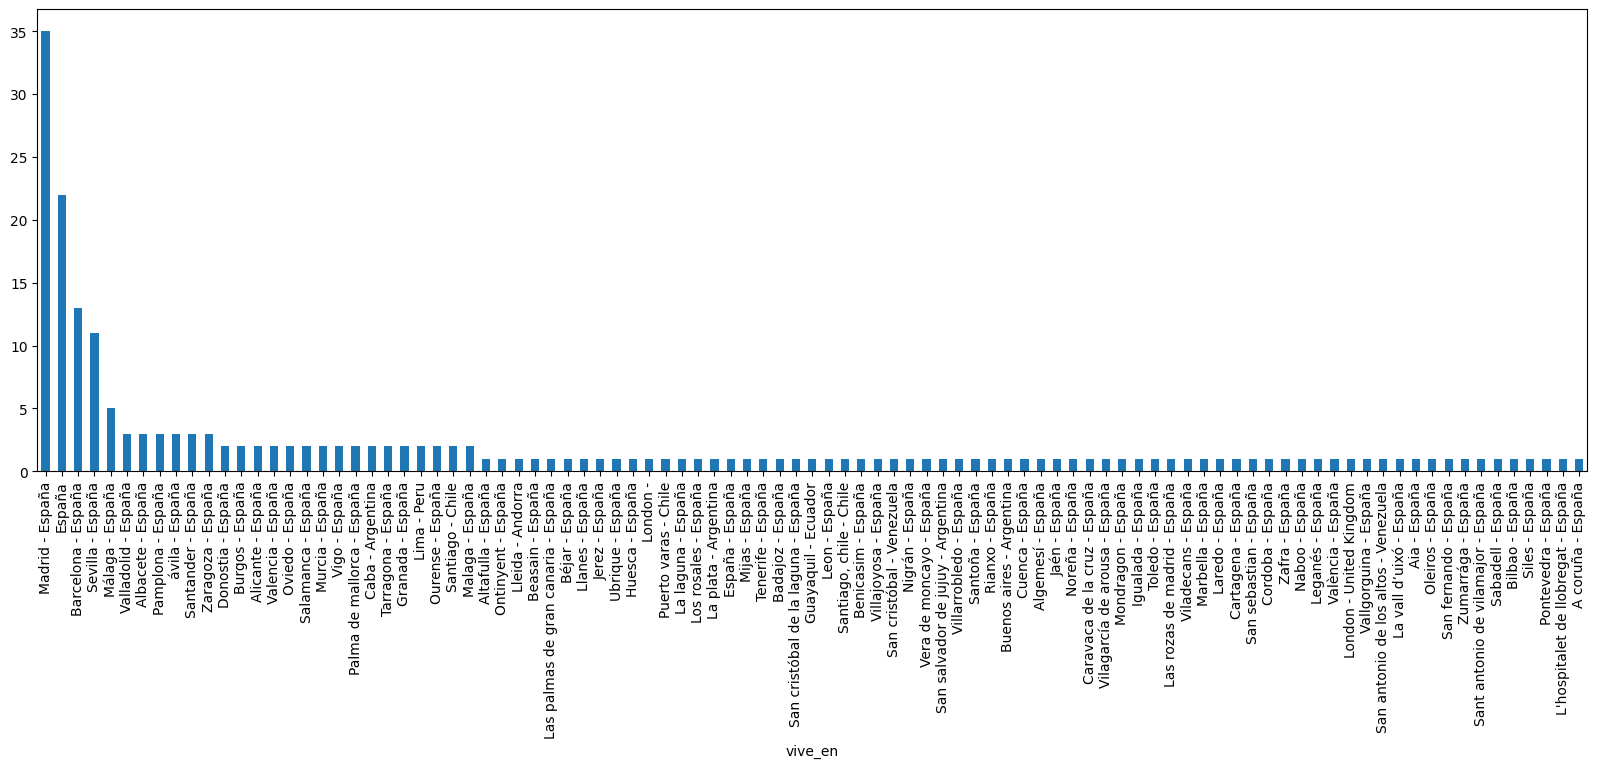

In [21]:
live_in=readers["vive_en"].value_counts()
live_in.plot(kind="bar", figsize=(20,6))

Lets simplify the origin of the readers to the country level

In [22]:
def vive_en(df):
    patron_españa=r"(?i)españa|espania|espana"
    patron_arg=r"(?i)Argentina|argentina"
    patron_UK=r"(?i)United|Kingdom|London"
    patron_peru=r"(?i)Peru|Perú"
    patron_ven=r"(?i)Venezuela|Venesuela"
    patron_chile=r"(?i)chile"
    patron_and=r"(?i)andorra"
    patron_ecu=r"(?i)ecuador"

    df.loc[df.vive_en.str.contains(patron_españa, na=False), "vive_en"] = "España"
    df.loc[df.vive_en.str.contains(patron_arg, na=False), "vive_en"] = "Argentina"
    df.loc[df.vive_en.str.contains(patron_UK, na=False), "vive_en"] = "UK"
    df.loc[df.vive_en.str.contains(patron_peru, na=False), "vive_en"] = "Peru"
    df.loc[df.vive_en.str.contains(patron_ven, na=False), "vive_en"] = "Venezuela"
    df.loc[df.vive_en.str.contains(patron_chile, na=False), "vive_en"] = "Chile"
    df.loc[df.vive_en.str.contains(patron_and, na=False), "vive_en"] = "Andorra"
    df.loc[df.vive_en.str.contains(patron_ecu, na=False), "vive_en"] = "Ecuador"
    #For Nan lets assume they live in Spain
    df.loc[df.vive_en.isna(), "vive_en"] = "España"

In [23]:
vive_en(readers)

<Axes: xlabel='vive_en'>

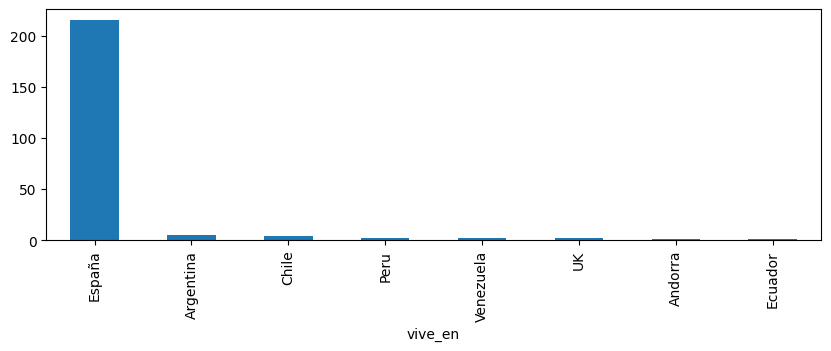

In [24]:
live_in=readers["vive_en"].value_counts()
live_in.plot(kind="bar", figsize=(10,3))

In [25]:
nulos(readers)

,Nan,Not NaN
genero,0,232
vive_en,0,232
nacimiento,35,197


Let´s input year of birth with the median grouped by sex

In [26]:
yb_male=round(readers[readers["genero"]=="Hombre"]["nacimiento"].median(),0)
yb_woman=round(readers[readers["genero"]=="Mujer"]["nacimiento"].median(),0)

mask_m=(readers["genero"]=="Hombre") & (readers["nacimiento"]).isna()
mask_w=(readers["genero"]=="Mujer") & ((readers["nacimiento"]).isna())

readers.loc[mask_m, "nacimiento"]=yb_male
readers.loc[mask_w, "nacimiento"]=yb_woman

In [27]:
nulos(readers)

,Nan,Not NaN
genero,0,232
vive_en,0,232
nacimiento,0,232


#### Preference DataFrame

This dataframe tell us which reader has read which book and whether they liked (1) or not (0) 

In [28]:
preference.head()

,id_libro,label
id_lector,,
71,esperando-al-diluvio,0
92,el-topo-que-queria-saber-quien-se-habia-hecho-...,1
19,las-torres-de-sancho,1
216,el-problema-final,1
59,central-park,1


In [29]:
print("Number of readers:", len(preference.index.unique()))
print("Number of books:", len(preference["id_libro"].unique()))

Number of readers: 232
Number of books: 16223


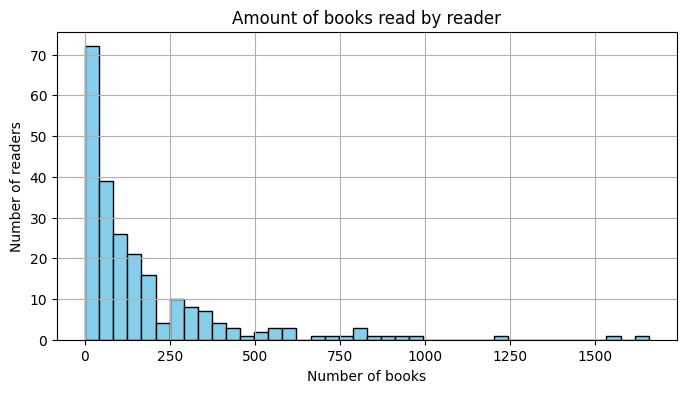

In [30]:
books_read_count=preference.groupby("id_lector").size()

plt.figure(figsize=(8,4))
plt.hist(books_read_count, bins=40, color="skyblue", edgecolor="black")
plt.title("Amount of books read by reader")
plt.xlabel("Number of books")
plt.ylabel("Number of readers")
plt.grid(True)

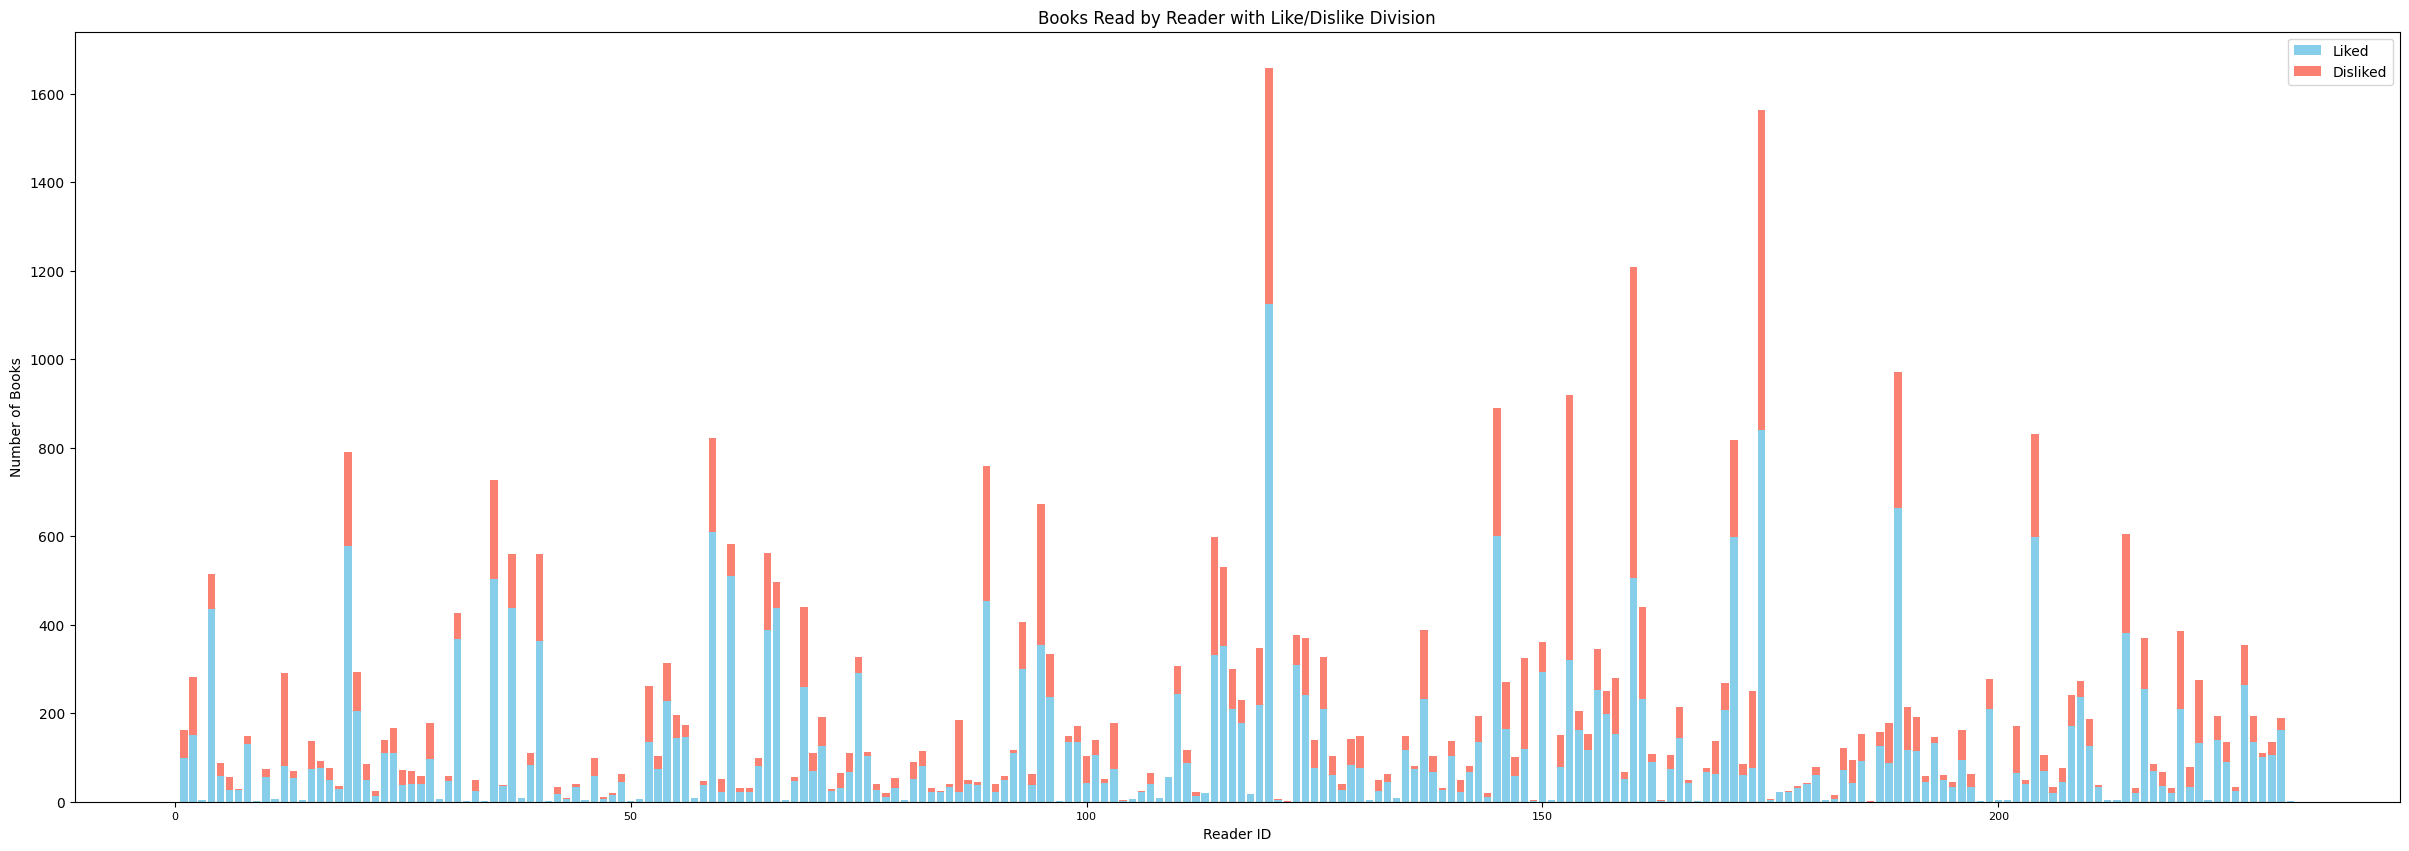

In [31]:
liked_disliked_counts = preference.groupby(["id_lector", "label"]).size().unstack(fill_value=0)

plt.figure(figsize=(30, 10))
liked_bars = plt.bar(liked_disliked_counts.index, liked_disliked_counts[1], label='Liked', color='skyblue')
disliked_bars = plt.bar(liked_disliked_counts.index, liked_disliked_counts[0], bottom=liked_disliked_counts[1], label='Disliked', color='salmon')

plt.title('Books Read by Reader with Like/Dislike Division')
plt.xlabel('Reader ID')
plt.ylabel('Number of Books')
plt.legend()
plt.xticks(fontsize=8)
plt.show()


### Dataframe Joining
Lets joing the three dataframes into a unique dataframe.

In [32]:
preference.head()

,id_libro,label
id_lector,,
71,esperando-al-diluvio,0
92,el-topo-que-queria-saber-quien-se-habia-hecho-...,1
19,las-torres-de-sancho,1
216,el-problema-final,1
59,central-park,1


In [33]:
books_calif.head()

,titulo,autor,genero,editorial,anio_edicion,mean_calification
id_libro,,,,,,
las-particulas-elementales,LAS PARTÍCULAS ELEMENTALES,"HOUELLEBECQ, MICHEL",Narrativa,ANAGRAMA,2006,7.39
quien-domina-el-mundo,¿QUIÉN DOMINA EL MUNDO?,"CHOMSKY, NOAM",Ensayo,EDICIONES B,2016,7.00
antimanual-de-filosofia,ANTIMANUAL DE FILOSOFÍA,"ONFRAY, MICHEL",Ensayo,EDAF,2011,8.50
momentos-estelares-de-la-humanidad-catorce-miniaturas-historicas,MOMENTOS ESTELARES DE LA HUMANIDAD: Catorce Mi...,"ZWEIG, STEFAN",Histórica y aventuras,ACANTILADO,2002,8.19
la-invencion-del-pasado,LA INVENCIÓN DEL PASADO,"MURADO, MIGUEL-ANXO",Varios,DEBATE,2013,8.50


In [34]:
# Start joining preference df to books_calification on preference.id_libro=books_calif.id_libro.
# For preference df the key is a column while for books_calif the key is the index

preference_books=pd.merge(preference, books_calif, how="left", left_on=["id_libro"], right_index=True)

In [35]:
preference_books.head()

,id_libro,label,titulo,autor,genero,editorial,anio_edicion,mean_calification
id_lector,,,,,,,,
71,esperando-al-diluvio,0,ESPERANDO AL DILUVIO,"REDONDO, DOLORES",Novela negra,DESTINO,2022,7.11
92,el-topo-que-queria-saber-quien-se-habia-hecho-...,1,EL TOPO QUE QUERÍA SABER QUIÉN SE HABÍA HECHO ...,"HOLZWARTH, WERNER y ERLBUCH, WOLF",Infantil,ALFAGUARA,2002,8.30
19,las-torres-de-sancho,1,LAS TORRES DE SANCHO,"MARTÍNEZ DE LEZEA, TOTI",Histórica y aventuras,MAEVA,2008,7.60
216,el-problema-final,1,EL PROBLEMA FINAL,"PEREZ REVERTE, ARTURO",Novela negra,ALFAGUARA,2023,8.00
59,central-park,1,CENTRAL PARK,"MUSSO, GUILLAUME",Novela negra,DEBOLSILLO,2015,6.35


In [36]:
# Now lets add the information about the reader with another left join on preference_books.id_lector=readers.id_lector
# For both dataframes the key is the index

In [37]:
readers.head()

,genero,vive_en,nacimiento
id_lector,,,
1,Hombre,España,1961.0
2,Mujer,España,1982.0
3,Mujer,España,1999.0
4,Hombre,España,1978.0
5,Hombre,España,1985.0


In [38]:
preference_books_readers=pd.merge(preference_books, readers, how="left", left_index=True, right_index=True)

In [39]:
preference_books_readers.head()

,id_libro,label,titulo,autor,genero_x,editorial,anio_edicion,mean_calification,genero_y,vive_en,nacimiento
id_lector,,,,,,,,,,,
71,esperando-al-diluvio,0,ESPERANDO AL DILUVIO,"REDONDO, DOLORES",Novela negra,DESTINO,2022,7.11,Hombre,España,1979.0
92,el-topo-que-queria-saber-quien-se-habia-hecho-...,1,EL TOPO QUE QUERÍA SABER QUIÉN SE HABÍA HECHO ...,"HOLZWARTH, WERNER y ERLBUCH, WOLF",Infantil,ALFAGUARA,2002,8.30,Hombre,España,1970.0
19,las-torres-de-sancho,1,LAS TORRES DE SANCHO,"MARTÍNEZ DE LEZEA, TOTI",Histórica y aventuras,MAEVA,2008,7.60,Mujer,España,1958.0
216,el-problema-final,1,EL PROBLEMA FINAL,"PEREZ REVERTE, ARTURO",Novela negra,ALFAGUARA,2023,8.00,Hombre,España,1981.0
59,central-park,1,CENTRAL PARK,"MUSSO, GUILLAUME",Novela negra,DEBOLSILLO,2015,6.35,Hombre,España,1952.0


In [40]:
#There were two columns with the same name (genero). Lets rename them for more clarity
preference_books_readers.rename(columns={"genero_x":"genero_literario", "genero_y":"sexo"}, inplace=True)

In [41]:
preference_books_readers.head()

,id_libro,label,titulo,autor,genero_literario,editorial,anio_edicion,mean_calification,sexo,vive_en,nacimiento
id_lector,,,,,,,,,,,
71,esperando-al-diluvio,0,ESPERANDO AL DILUVIO,"REDONDO, DOLORES",Novela negra,DESTINO,2022,7.11,Hombre,España,1979.0
92,el-topo-que-queria-saber-quien-se-habia-hecho-...,1,EL TOPO QUE QUERÍA SABER QUIÉN SE HABÍA HECHO ...,"HOLZWARTH, WERNER y ERLBUCH, WOLF",Infantil,ALFAGUARA,2002,8.30,Hombre,España,1970.0
19,las-torres-de-sancho,1,LAS TORRES DE SANCHO,"MARTÍNEZ DE LEZEA, TOTI",Histórica y aventuras,MAEVA,2008,7.60,Mujer,España,1958.0
216,el-problema-final,1,EL PROBLEMA FINAL,"PEREZ REVERTE, ARTURO",Novela negra,ALFAGUARA,2023,8.00,Hombre,España,1981.0
59,central-park,1,CENTRAL PARK,"MUSSO, GUILLAUME",Novela negra,DEBOLSILLO,2015,6.35,Hombre,España,1952.0


In [42]:
nulos(preference_books_readers)

,Nan,Not NaN
id_libro,0,41330
label,0,41330
titulo,173,41157
autor,282,41048
genero_literario,282,41048
editorial,287,41043
anio_edicion,307,41023
mean_calification,377,40953
sexo,0,41330
vive_en,0,41330


There are a few nan rows...we are gonna drop them

In [43]:
preference_books_readers.dropna(inplace=True)

In [44]:
nulos(preference_books_readers)

,Nan,Not NaN
id_libro,0,40842
label,0,40842
titulo,0,40842
autor,0,40842
genero_literario,0,40842
editorial,0,40842
anio_edicion,0,40842
mean_calification,0,40842
sexo,0,40842
vive_en,0,40842


Since each combination of book and reader is unique we can use these two columns to set up a new index

In [45]:
preference_books_readers["id_reader"]=preference_books_readers.index
preference_books_readers["id_reader_id_book"]=preference_books_readers["id_reader"].astype(str) + "--" + preference_books_readers["id_libro"].astype(str)
preference_books_readers.set_index("id_reader_id_book", inplace=True)

#### Now that we have our dataframe ready and clean lets split between Development (Train+Validation) and Test

In [46]:
preference_books_readers.head()

,id_libro,label,titulo,autor,genero_literario,editorial,anio_edicion,mean_calification,sexo,vive_en,nacimiento,id_reader
id_reader_id_book,,,,,,,,,,,,
71--esperando-al-diluvio,esperando-al-diluvio,0,ESPERANDO AL DILUVIO,"REDONDO, DOLORES",Novela negra,DESTINO,2022,7.11,Hombre,España,1979.0,71
92--el-topo-que-queria-saber-quien-se-habia-hecho-aquello-en-su-cabeza,el-topo-que-queria-saber-quien-se-habia-hecho-...,1,EL TOPO QUE QUERÍA SABER QUIÉN SE HABÍA HECHO ...,"HOLZWARTH, WERNER y ERLBUCH, WOLF",Infantil,ALFAGUARA,2002,8.30,Hombre,España,1970.0,92
19--las-torres-de-sancho,las-torres-de-sancho,1,LAS TORRES DE SANCHO,"MARTÍNEZ DE LEZEA, TOTI",Histórica y aventuras,MAEVA,2008,7.60,Mujer,España,1958.0,19
216--el-problema-final,el-problema-final,1,EL PROBLEMA FINAL,"PEREZ REVERTE, ARTURO",Novela negra,ALFAGUARA,2023,8.00,Hombre,España,1981.0,216
59--central-park,central-park,1,CENTRAL PARK,"MUSSO, GUILLAUME",Novela negra,DEBOLSILLO,2015,6.35,Hombre,España,1952.0,59


### Spliting the dataset: Development(Train+Validation) / Test

Our objetive is to train a model that can predict if a certain reader will like certain book. Thus, once trained, our model will only recieve the reader´s id and the book´s id as input.
To avoid data leakeage lets split the dataset into Development and Test, and calculate some extra features on Development that then will be added to Test

In [47]:
dev, test=train_test_split(preference_books_readers, test_size=0.2, random_state=42)

¿Do all readers in test are in Dev?

In [48]:
test["id_reader"].isin(dev["id_reader"]).value_counts()

id_reader
True     8168
False       1
Name: count, dtype: int64

In [49]:
# For model training lets only keep readers in test that are also in train
mask=test["id_reader"].isin(dev["id_reader"])
test_sample=test[mask]

In [50]:
test_sample["id_reader"].isin(dev["id_reader"]).value_counts()

id_reader
True    8168
Name: count, dtype: int64

### Extra features

One way to predict if a book is going to be liked by a reader is to see if the book´s gender is one of the reader´s favourite genders.
Let´s start by finding out which gender does each reader prefers

In [51]:
liked=dev[dev["label"]==1]
liked_byreader=liked.groupby(["id_reader", "genero_literario"])["genero_literario"].value_counts().reset_index(name="count")
liked_byreader.sort_values(["id_reader", "count"], ascending=[True, False], inplace=True)
liked_byreader.drop_duplicates(subset="id_reader", keep="first", inplace=True)
fav_gender=liked_byreader.drop(columns=["count"])

In [52]:
fav_gender.set_index("id_reader", inplace=True)
fav_gender.rename(columns={"genero_literario":"favorite_gender"}, inplace=True)
fav_gender.head()

,favorite_gender
id_reader,
1,Novela negra
2,Novela negra
3,Literatura contemporánea
4,Narrativa
5,Novela negra


Now lets add a new column in Dev and Test to determine if certain book´s gender is the reader´s favourite gender

In [53]:
dev=pd.merge(dev, fav_gender,how="left",left_on=["id_reader"], right_index=True)
dev["is_favorite_gender"]=(dev["genero_literario"]==dev["favorite_gender"]).astype(int)
dev.drop(columns="favorite_gender", inplace= True)
dev.head()

,id_libro,label,titulo,autor,genero_literario,editorial,anio_edicion,mean_calification,sexo,vive_en,nacimiento,id_reader,is_favorite_gender
id_reader_id_book,,,,,,,,,,,,,
174--blacksad-1-un-lugar-entre-las-sombras,blacksad-1-un-lugar-entre-las-sombras,1,BLACKSAD 1. Un lugar entre las sombras,"DÍAZ CANALES, JUAN y GUARNIDO, JUANJO",Cómics,NORMA,2000,8.19,Hombre,España,1978.0,174,1
120--harry-potter-y-el-misterio-del-principe,harry-potter-y-el-misterio-del-principe,0,HARRY POTTER Y EL MISTERIO DEL PRINCIPE,"ROWLING, JOANNE K.",Infantil,SALAMANDRA,2006,7.93,Hombre,España,1980.0,120,0
153--el-cartero-de-neruda-ardiente-paciencia,el-cartero-de-neruda-ardiente-paciencia,1,EL CARTERO DE NERUDA (Ardiente paciencia),"SKÁRMETA, ANTONIO",Literatura contemporánea,DEBOLSILLO,2014,7.21,Mujer,España,1978.0,153,0
189--el-diario-de-bridget-jones,el-diario-de-bridget-jones,0,EL DIARIO DE BRIDGET JONES,"FIELDING, HELEN",Romántica,DEBOLSILLO,2003,6.38,Mujer,España,1969.0,189,0
218--v13-cronica-judicial,v13-cronica-judicial,1,V13. Crónica judicial,"CARRÈRE, EMMANUEL",No ficción,ANAGRAMA,2023,8.40,Hombre,España,1974.0,218,0


Now we do the same in test

In [54]:
test_sample=pd.merge(test_sample, fav_gender,how="left",left_on=["id_reader"], right_index=True)
test_sample["is_favorite_gender"]=(test_sample["genero_literario"]==test_sample["favorite_gender"]).astype(int)
test_sample.drop(columns="favorite_gender", inplace=True)
test_sample.head()

,id_libro,label,titulo,autor,genero_literario,editorial,anio_edicion,mean_calification,sexo,vive_en,nacimiento,id_reader,is_favorite_gender
id_reader_id_book,,,,,,,,,,,,,
160--un-cadaver-en-los-banos-la-xiii-novela-de-marco-didio-falco,un-cadaver-en-los-banos-la-xiii-novela-de-marc...,0,UN CADÁVER EN LOS BAÑOS. La XIII novela de Mar...,"DAVIS, LINDSEY",Histórica y aventuras,EDHASA,2005,7.73,Hombre,España,1948.0,160,0
185--cuentos-5,cuentos-5,1,CUENTOS,"POE, EDGAR ALLAN",Novela negra,ESPASA,2007,10.00,Mujer,España,1978.0,185,0
207--los-vecinos-mueren-en-las-novelas,los-vecinos-mueren-en-las-novelas,1,LOS VECINOS MUEREN EN LAS NOVELAS,"AGUIRRE, SERGIO",Literatura contemporánea,NORMA,2013,8.18,Hombre,Argentina,1993.0,207,0
120--si-esto-es-una-mujer,si-esto-es-una-mujer,1,SI ESTO ES UNA MUJER,"SILVA, LORENZO y TRUJILLO, NOEMÍ",Novela negra,DESTINO,2019,6.97,Hombre,España,1980.0,120,0
171--el-jardin-olvidado,el-jardin-olvidado,1,EL JARDÍN OLVIDADO,"MORTON, KATE",Narrativa,SUMA DE LETRAS,2010,7.60,Mujer,España,1970.0,171,1


Now we gonna find out each reader´s favourite author

In [55]:
liked=dev[dev["label"]==1]
author_liked_byreader=liked.groupby(["id_reader", "autor"])["autor"].value_counts().reset_index(name="count")
author_liked_byreader.sort_values(["id_reader", "count"], ascending=[True, False], inplace=True)
author_liked_byreader.drop_duplicates(subset="id_reader", keep="first", inplace=True)
fav_author=author_liked_byreader.drop(columns=["count"])

fav_author.set_index("id_reader", inplace=True)
fav_author.rename(columns={"autor":"favorite_author"}, inplace=True)
fav_author.head()

,favorite_author
id_reader,
1,"BOYLE, T.C. (Thomas Coraghessan Boyle)"
2,"BLYTON, ENID"
3,"DYER, WAYNE W."
4,"VÁZQUEZ-FIGUEROA, ALBERTO"
5,"TOLKIEN, J.R.R. (John Ronald Reuel Tolkien)"


In [56]:
dev=pd.merge(dev, fav_author,how="left",left_on=["id_reader"], right_index=True)
dev["is_favorite_author"]=(dev["autor"]==dev["favorite_author"]).astype(int)
dev.drop(columns='favorite_author', inplace=True)
dev.head()

,id_libro,label,titulo,autor,genero_literario,editorial,anio_edicion,mean_calification,sexo,vive_en,nacimiento,id_reader,is_favorite_gender,is_favorite_author
id_reader_id_book,,,,,,,,,,,,,,
174--blacksad-1-un-lugar-entre-las-sombras,blacksad-1-un-lugar-entre-las-sombras,1,BLACKSAD 1. Un lugar entre las sombras,"DÍAZ CANALES, JUAN y GUARNIDO, JUANJO",Cómics,NORMA,2000,8.19,Hombre,España,1978.0,174,1,0
120--harry-potter-y-el-misterio-del-principe,harry-potter-y-el-misterio-del-principe,0,HARRY POTTER Y EL MISTERIO DEL PRINCIPE,"ROWLING, JOANNE K.",Infantil,SALAMANDRA,2006,7.93,Hombre,España,1980.0,120,0,0
153--el-cartero-de-neruda-ardiente-paciencia,el-cartero-de-neruda-ardiente-paciencia,1,EL CARTERO DE NERUDA (Ardiente paciencia),"SKÁRMETA, ANTONIO",Literatura contemporánea,DEBOLSILLO,2014,7.21,Mujer,España,1978.0,153,0,0
189--el-diario-de-bridget-jones,el-diario-de-bridget-jones,0,EL DIARIO DE BRIDGET JONES,"FIELDING, HELEN",Romántica,DEBOLSILLO,2003,6.38,Mujer,España,1969.0,189,0,0
218--v13-cronica-judicial,v13-cronica-judicial,1,V13. Crónica judicial,"CARRÈRE, EMMANUEL",No ficción,ANAGRAMA,2023,8.40,Hombre,España,1974.0,218,0,0


We do the same on test

In [57]:
test_sample=pd.merge(test_sample, fav_author,how="left",left_on=["id_reader"], right_index=True)
test_sample["is_favorite_author"]=(test_sample["autor"]==test_sample["favorite_author"]).astype(int)
test_sample.drop(columns="favorite_author", inplace=True)
test_sample.head(5)

,id_libro,label,titulo,autor,genero_literario,editorial,anio_edicion,mean_calification,sexo,vive_en,nacimiento,id_reader,is_favorite_gender,is_favorite_author
id_reader_id_book,,,,,,,,,,,,,,
160--un-cadaver-en-los-banos-la-xiii-novela-de-marco-didio-falco,un-cadaver-en-los-banos-la-xiii-novela-de-marc...,0,UN CADÁVER EN LOS BAÑOS. La XIII novela de Mar...,"DAVIS, LINDSEY",Histórica y aventuras,EDHASA,2005,7.73,Hombre,España,1948.0,160,0,0
185--cuentos-5,cuentos-5,1,CUENTOS,"POE, EDGAR ALLAN",Novela negra,ESPASA,2007,10.00,Mujer,España,1978.0,185,0,0
207--los-vecinos-mueren-en-las-novelas,los-vecinos-mueren-en-las-novelas,1,LOS VECINOS MUEREN EN LAS NOVELAS,"AGUIRRE, SERGIO",Literatura contemporánea,NORMA,2013,8.18,Hombre,Argentina,1993.0,207,0,0
120--si-esto-es-una-mujer,si-esto-es-una-mujer,1,SI ESTO ES UNA MUJER,"SILVA, LORENZO y TRUJILLO, NOEMÍ",Novela negra,DESTINO,2019,6.97,Hombre,España,1980.0,120,0,0
171--el-jardin-olvidado,el-jardin-olvidado,1,EL JARDÍN OLVIDADO,"MORTON, KATE",Narrativa,SUMA DE LETRAS,2010,7.60,Mujer,España,1970.0,171,1,0


Transform into dummy_variables sex and place of birth

In [58]:
dev=pd.get_dummies(dev, columns=["sexo"], dtype=int)
dev=pd.get_dummies(dev, columns=["vive_en"], dtype=int)
test_sample=pd.get_dummies(test_sample, columns=["sexo"], dtype=int)
test_sample=pd.get_dummies(test_sample, columns=["vive_en"], dtype=int)


Keep only numerical values

In [59]:
dev = dev.select_dtypes(include=['float64', 'int64', 'int32', 'int16', 'int8', 'bool'])
test_sample=test_sample.select_dtypes(include=['float64', 'int64', 'int32', 'int16', 'int8', 'bool'])
dev.head()


,label,mean_calification,nacimiento,id_reader,is_favorite_gender,is_favorite_author,sexo_Hombre,sexo_Mujer,vive_en_Andorra,vive_en_Argentina,vive_en_Chile,vive_en_Ecuador,vive_en_España,vive_en_Peru,vive_en_UK,vive_en_Venezuela
id_reader_id_book,,,,,,,,,,,,,,,,
174--blacksad-1-un-lugar-entre-las-sombras,1,8.19,1978.0,174,1,0,1,0,0,0,0,0,1,0,0,0
120--harry-potter-y-el-misterio-del-principe,0,7.93,1980.0,120,0,0,1,0,0,0,0,0,1,0,0,0
153--el-cartero-de-neruda-ardiente-paciencia,1,7.21,1978.0,153,0,0,0,1,0,0,0,0,1,0,0,0
189--el-diario-de-bridget-jones,0,6.38,1969.0,189,0,0,0,1,0,0,0,0,1,0,0,0
218--v13-cronica-judicial,1,8.40,1974.0,218,0,0,1,0,0,0,0,0,1,0,0,0


In [60]:
test_sample.head()

,label,mean_calification,nacimiento,id_reader,is_favorite_gender,is_favorite_author,sexo_Hombre,sexo_Mujer,vive_en_Andorra,vive_en_Argentina,vive_en_Chile,vive_en_Ecuador,vive_en_España,vive_en_Peru,vive_en_UK,vive_en_Venezuela
id_reader_id_book,,,,,,,,,,,,,,,,
160--un-cadaver-en-los-banos-la-xiii-novela-de-marco-didio-falco,0,7.73,1948.0,160,0,0,1,0,0,0,0,0,1,0,0,0
185--cuentos-5,1,10.00,1978.0,185,0,0,0,1,0,0,0,0,1,0,0,0
207--los-vecinos-mueren-en-las-novelas,1,8.18,1993.0,207,0,0,1,0,0,1,0,0,0,0,0,0
120--si-esto-es-una-mujer,1,6.97,1980.0,120,0,0,1,0,0,0,0,0,1,0,0,0
171--el-jardin-olvidado,1,7.60,1970.0,171,1,0,0,1,0,0,0,0,1,0,0,0


Drop id_reader

In [61]:
dev.drop(columns="id_reader",inplace=True)
test_sample.drop(columns="id_reader",inplace=True)

 Divide X and y in development

In [62]:
X_trainval = dev.drop(columns=['label'])
y_trainval = dev['label']

### Baseline approach: Logistic regression

In [63]:
# Imports necesarios
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.metrics import log_loss, confusion_matrix, f1_score
import numpy as np
import seaborn as sns

Mean F1-score in Train after 5 iterations: 0.8234
Mean F1-score in Test after 5 iterations: 0.8252


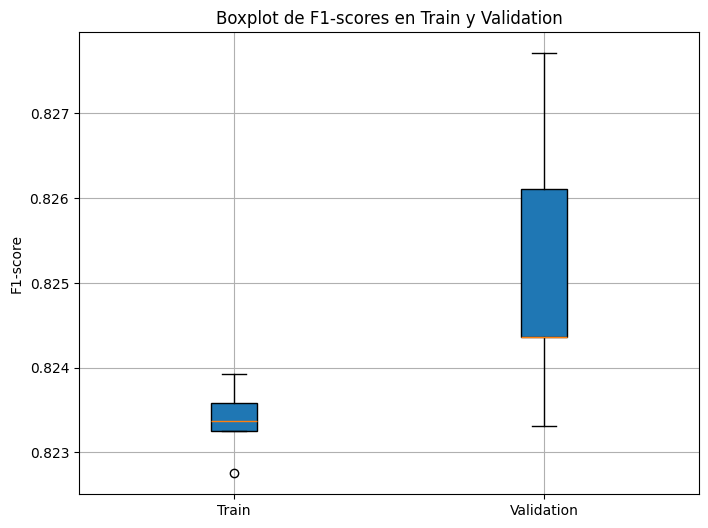

In [64]:
# Initializite lists for scores recording
f1_train_scores = []
f1_val_scores = []

# We´re going to do the task 5 times to include variability
for i in range(5):
    # Split the dataset into train and validation
    X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, stratify=y_trainval, test_size=0.2, random_state=i)

    # Create baseline model without regularization
    model = LogisticRegression(max_iter=1000)
    scaler = StandardScaler()

    # Scale data of train and validation
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Traind model with train data
    model.fit(X_train, y_train)

    # Make predictions with train and validation data
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Calculate f1 score
    f1_train = f1_score(y_train, y_train_pred)
    f1_val = f1_score(y_val, y_val_pred)

    # Print f1 scores
    #print(f"Iteración {i + 1}, F1-score (Train): {f1_train:.4f}, F1-score (Val): {f1_val:.4f}")

    # Save f1 scores
    f1_train_scores.append(f1_train)
    f1_val_scores.append(f1_val)

# Show mean f1 score
f1_train_promedio = np.mean(f1_train_scores)
f1_val_promedio = np.mean(f1_val_scores)
print(f"Mean F1-score in Train after 5 iterations: {f1_train_promedio:.4f}")
print(f"Mean F1-score in Test after 5 iterations: {f1_val_promedio:.4f}")

# Boxplot with F1 scores
plt.figure(figsize=(8, 6))
plt.boxplot([f1_train_scores, f1_val_scores], labels=['Train', 'Validation'], patch_artist=True)
plt.title('Boxplot de F1-scores en Train y Validation')
plt.ylabel('F1-score')
plt.grid(True)
plt.show()

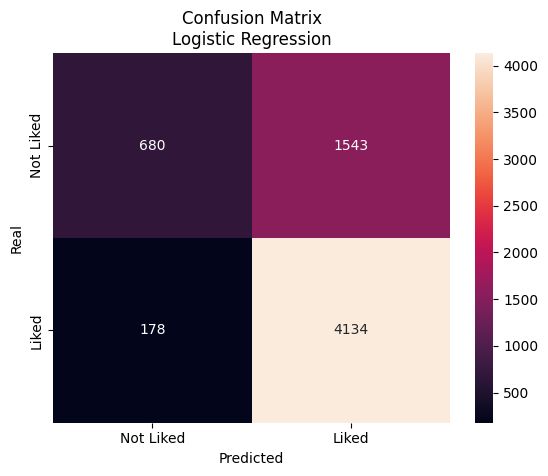

In [65]:
#Confution matrix for the last prediction

g = sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True, fmt='d')
g.set_xlabel('Predicted')
g.set_ylabel('Real')

g.set_title('Confusion Matrix\nLogistic Regression')

g.set_xticklabels(['Not Liked', 'Liked'])
g.set_yticklabels(['Not Liked', 'Liked'])

plt.show()

Let´s add some hyperparameter tunning to see if we can improve the metric

In [78]:
from sklearn.model_selection import GridSearchCV


# Base model
model = LogisticRegression(max_iter=1000)

# Valid parameter grid: matching solvers and penalties
param_grid = [
    {
        'penalty': ['l2'],
        'C': np.logspace(-3, 1, 5),
        'solver': ['lbfgs', 'liblinear']
    },
    {
        'penalty': ['l1'],
        'C': np.logspace(-3, 1, 5),
        'solver': ['liblinear', 'saga']
    },
    {
        'penalty': ['elasticnet'],
        'C': np.logspace(-3, 1, 5),
        'l1_ratio': np.linspace(0, 1, 5),
        'solver': ['saga']
    },
    {
        'penalty': ['none'],
        'solver': ['lbfgs', 'saga']
    }
]

n_splits = 5
best_params_list = []
model_list = []
f1_comparisons = []

for i in range(n_splits):
    # Split development into train/val
    X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, stratify=y_trainval, test_size=0.2, random_state=i)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Grid Search with cross-validation inside training set
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='f1',
        cv=5,
        n_jobs=-1,
        verbose=3
    )

    # Fit and evaluate
    grid_search.fit(X_train_scaled, y_train)
    best_params = grid_search.best_params_
    best_params_list.append(best_params)

    # Train final model for this split
    best_model = LogisticRegression(**best_params, max_iter=1000)
    best_model.fit(X_train_scaled, y_train)
    model_list.append(best_model)

    # Evaluate on validation set
    y_val_pred = best_model.predict(X_val_scaled)
    f1_best_model = np.round(f1_score(y_val, y_val_pred), 3)

    f1_comparisons.append({
        'Split': i + 1,
        'F1 Score': f1_best_model,
        'Best Params': best_params
    })

# Summary: best params per split
print("\nBest hyperparameters for each split:")
for entry in f1_comparisons:
    print(f"Split {entry['Split']}: F1_Validation = {entry['F1 Score']}, Params = {entry['Best Params']}")


Fitting 5 folds for each of 47 candidates, totalling 235 fits
Fitting 5 folds for each of 47 candidates, totalling 235 fits
Fitting 5 folds for each of 47 candidates, totalling 235 fits
Fitting 5 folds for each of 47 candidates, totalling 235 fits
Fitting 5 folds for each of 47 candidates, totalling 235 fits

Best hyperparameters for each split:
Split 1: F1_Validation = 0.825, Params = {'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}
Split 2: F1_Validation = 0.822, Params = {'C': 0.01, 'l1_ratio': 0.75, 'penalty': 'elasticnet', 'solver': 'saga'}
Split 3: F1_Validation = 0.825, Params = {'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}
Split 4: F1_Validation = 0.827, Params = {'C': 0.01, 'l1_ratio': 0.75, 'penalty': 'elasticnet', 'solver': 'saga'}
Split 5: F1_Validation = 0.828, Params = {'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}


We can observe that the F1 are similar between splits and similar to the base model. This suggest that the model is generaly robust.
Although there are some differences betweeen best parameters according to the split, we can see some consistency in some of them (like regularization parameter c was 0.01 in most splits)

Thus, we can choose a set of general hyperparametrs:

LogisticRegression(C=0.01, penalty='elasticnet', l1_ratio=0.75, solver='saga')


### Decision Tree

Iteración 1: F1-score (Train) = 0.8935, F1-score (Validation) = 0.7517
Iteración 2: F1-score (Train) = 0.8935, F1-score (Validation) = 0.7537
Iteración 3: F1-score (Train) = 0.8942, F1-score (Validation) = 0.7530
Iteración 4: F1-score (Train) = 0.8925, F1-score (Validation) = 0.7575
Iteración 5: F1-score (Train) = 0.8924, F1-score (Validation) = 0.7545

F1-score promedio en Train: 0.8932
F1-score promedio en Validation: 0.7541


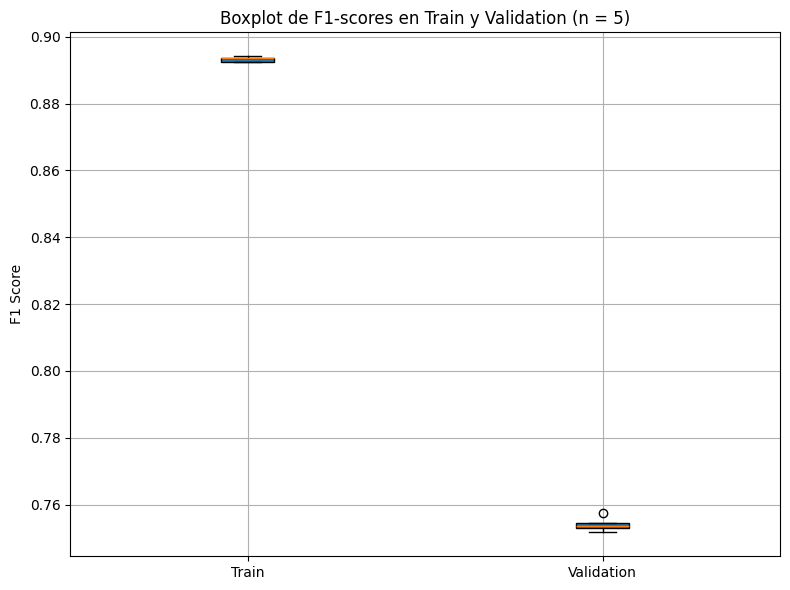

In [67]:
# Lets start with default model

from sklearn.tree import DecisionTreeClassifier

# Number of partitions
n_particiones = 5

# List for results
f1_train_scores = []
f1_val_scores = []

#  We´re going to do the task 5 times to include variability
for i in range(n_particiones):
    # Differen train and validation splits
    X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, stratify=y_trainval, test_size=0.2, random_state=i)

    #Scale
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    # Train model
    tree = DecisionTreeClassifier(random_state=42)
    tree.fit(X_train, y_train)

    # Predict in train
    y_train_pred = tree.predict(X_train)
    f1_train = f1_score(y_train, y_train_pred, average='binary')
    f1_train_scores.append(f1_train)

    # Predecir in validation
    y_val_pred = tree.predict(X_val)
    f1_val = f1_score(y_val, y_val_pred, average='binary')
    f1_val_scores.append(f1_val)

    # Print F1 for each partition
    print(f"Iteración {i + 1}: F1-score (Train) = {f1_train:.4f}, F1-score (Validation) = {f1_val:.4f}")

# Mean F1 score for train and validation
f1_train_promedio = np.mean(f1_train_scores)
f1_val_promedio = np.mean(f1_val_scores)

print(f"\nF1-score promedio en Train: {f1_train_promedio:.4f}")
print(f"F1-score promedio en Validation: {f1_val_promedio:.4f}")

# Graph mean F1 for train and development
plt.figure(figsize=(8, 6))
plt.boxplot([f1_train_scores, f1_val_scores], labels=['Train', 'Validation'], patch_artist=True)
plt.title('Boxplot de F1-scores en Train y Validation (n = {})'.format(n_particiones))
plt.ylabel('F1 Score')
plt.grid(True)
plt.tight_layout()
plt.show()



Hyperparameter tunning for decission tree

In [68]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from scipy.stats import randint, expon
import numpy as np

# Setup
n_splits = 5
f1_comparisons = []
best_params_list = []
model_list = []

# Search space for Decision Tree
param_dist = {
    'criterion': ["gini", "entropy"],
    'max_depth': range(1, 21),
    'max_features': randint(1, X_trainval.shape[1]),
    'min_samples_split': randint(2, 30),
    'min_samples_leaf': randint(1, 10),
    'ccp_alpha': expon(scale=0.1)
}

# Iterate over manual splits
for i in range(n_splits):
    print(f"\n--- Split {i+1} ---")
    
    # Create split
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval,
        stratify=y_trainval,
        test_size=0.2,
        random_state=i
    )

    # Define base model
    modelo_a_optimizar = DecisionTreeClassifier(random_state=42)

    # Randomized SearchCV
    search = RandomizedSearchCV(
        modelo_a_optimizar,
        param_distributions=param_dist,
        n_iter=100,
        cv=5,
        scoring='f1',
        n_jobs=-1,
        verbose=2,
        random_state=42
    )

    # Fit search
    search.fit(X_train, y_train)
    best_params = search.best_params_
    best_params_list.append(best_params)

    # Train model with best hyperparameters
    best_tree = DecisionTreeClassifier(
        max_depth=best_params['max_depth'],
        ccp_alpha=best_params['ccp_alpha'],
        criterion=best_params['criterion'],
        max_features=best_params['max_features'],
        min_samples_leaf=best_params['min_samples_leaf'],
        min_samples_split=best_params['min_samples_split'],
        random_state=42
    )
    best_tree.fit(X_train, y_train)
    model_list.append(best_tree)

    # Evaluate
    y_pred_val = best_tree.predict(X_val)
    f1 = np.round(f1_score(y_val, y_pred_val), 3)

    f1_comparisons.append({
        'Split': i + 1,
        'F1 Score': f1,
        'Best Params': best_params
    })

# Summary
print("\nBest hyperparameters for each split:")
for entry in f1_comparisons:
    print(f"Split {entry['Split']}: F1 = {entry['F1 Score']}, Params = {entry['Best Params']}")



--- Split 1 ---
Fitting 5 folds for each of 100 candidates, totalling 500 fits

--- Split 2 ---
Fitting 5 folds for each of 100 candidates, totalling 500 fits

--- Split 3 ---
Fitting 5 folds for each of 100 candidates, totalling 500 fits

--- Split 4 ---
Fitting 5 folds for each of 100 candidates, totalling 500 fits

--- Split 5 ---
Fitting 5 folds for each of 100 candidates, totalling 500 fits

Best hyperparameters for each split:
Split 1: F1 = 0.817, Params = {'ccp_alpha': 0.0006976409181650647, 'criterion': 'entropy', 'max_depth': 9, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 20}
Split 2: F1 = 0.817, Params = {'ccp_alpha': 0.0006976409181650647, 'criterion': 'entropy', 'max_depth': 9, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 20}
Split 3: F1 = 0.816, Params = {'ccp_alpha': 0.0014179883757114943, 'criterion': 'gini', 'max_depth': 17, 'max_features': 8, 'min_samples_leaf': 3, 'min_samples_split': 4}
Split 4: F1 = 0.822, Params = {'ccp_alpha':

There´s a clear improvement (from 0.749 to ~0.82) when hyperparameters are tunned. However the F1 for validation is similar to the found for the linnear regression.

Once again the best hyperparamets varies accoording to split. We´ll choose the one that appears in more splits and with higher f1 and lower depht(more simple):

best_tree_params={'ccp_alpha': 0.0006976409181650647,
 'criterion': 'entropy',
 'max_depth': 9,
 'max_features': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 20}

### Random Forest

Iteration 1: F1-score (Train) = 0.8973, F1-score (Validation) = 0.7838
Iteration 2: F1-score (Train) = 0.8973, F1-score (Validation) = 0.7833
Iteration 3: F1-score (Train) = 0.8978, F1-score (Validation) = 0.7821
Iteration 4: F1-score (Train) = 0.8964, F1-score (Validation) = 0.7901
Iteration 5: F1-score (Train) = 0.8962, F1-score (Validation) = 0.7815

 Mean F1 in Train: 0.8970
Mean F1 in Validation: 0.7842


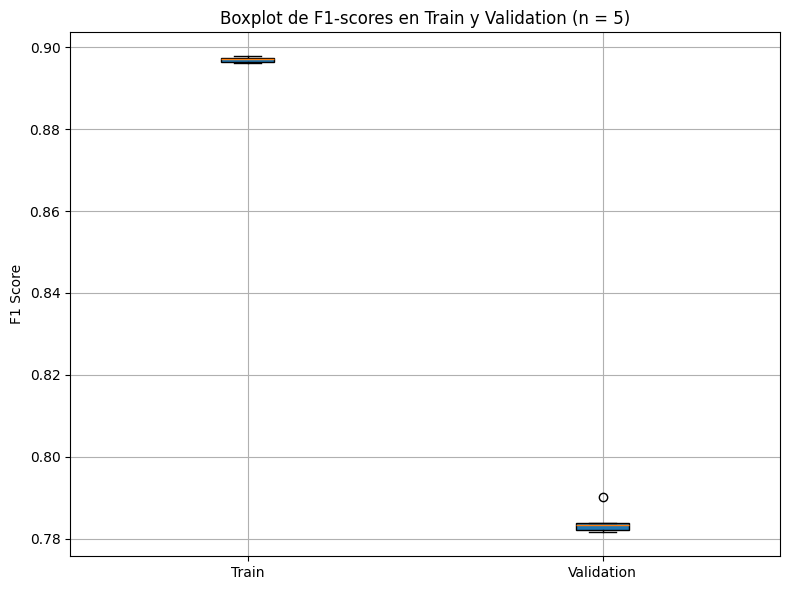

In [69]:

from sklearn.ensemble import RandomForestClassifier
#Number of partitions
n_particiones = 5

# List for results
f1_train_scores = []
f1_val_scores = []

#  We´re going to do the task 5 times to include variability
for i in range(n_particiones):
    # Differen train and validation splits
    X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, stratify=y_trainval, test_size=0.2, random_state=i)


    # Initialize and train the Baseline RandomForestClassifier
    reg = RandomForestClassifier(random_state=42)
    reg.fit(X_train, y_train)

    # Predict in train
    y_train_pred = reg.predict(X_train)
    f1_train = f1_score(y_train, y_train_pred, average='binary')
    f1_train_scores.append(f1_train)

    # Predict in validation
    y_val_pred = reg.predict(X_val)
    f1_val = f1_score(y_val, y_val_pred, average='binary')
    f1_val_scores.append(f1_val)

    # Print F1 for each partition
    print(f"Iteration {i + 1}: F1-score (Train) = {f1_train:.4f}, F1-score (Validation) = {f1_val:.4f}")

# Mean F1 score for train and validation
f1_train_promedio = np.mean(f1_train_scores)
f1_val_promedio = np.mean(f1_val_scores)

print(f"\n Mean F1 in Train: {f1_train_promedio:.4f}")
print(f"Mean F1 in Validation: {f1_val_promedio:.4f}")

# Graph mean F1 for train and development
plt.figure(figsize=(8, 6))
plt.boxplot([f1_train_scores, f1_val_scores], labels=['Train', 'Validation'], patch_artist=True)
plt.title('Boxplot de F1-scores en Train y Validation (n = {})'.format(n_particiones))
plt.ylabel('F1 Score')
plt.grid(True)
plt.tight_layout()
plt.show()



In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import f1_score
from scipy.stats import randint, uniform
import numpy as np

# Setup
n_splits = 5
f1_comparisons = []
best_params_list = []
model_list = []

# Random Forest hyperparameter search space
param_dist = {
    'n_estimators': randint(100, 500),               # Number of trees
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(5, 30),
    'max_features': ['sqrt', 'log2', None],          # None = all features
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'bootstrap': [True, False]
}

# Iterate over manual splits
for i in range(n_splits):
    print(f"\n--- Split {i+1} ---")

    # Split
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval,
        stratify=y_trainval,
        test_size=0.2,
        random_state=i
    )

    # Base model
    modelo_a_optimizar = RandomForestClassifier(random_state=42, n_jobs=-1)

    # Randomized SearchCV
    search = RandomizedSearchCV(
        modelo_a_optimizar,
        param_distributions=param_dist,
        n_iter=10,
        cv=5,
        scoring='f1',
        n_jobs=-1,
        verbose=2,
        random_state=42
    )

    # Fit search
    search.fit(X_train, y_train)
    best_params = search.best_params_
    best_params_list.append(best_params)

    # Train model with best hyperparameters
    best_forest = RandomForestClassifier(
        **best_params,
        random_state=42,
        n_jobs=-1
    )
    best_forest.fit(X_train, y_train)
    model_list.append(best_forest)

    # Evaluate
    y_pred_val = best_forest.predict(X_val)
    f1 = np.round(f1_score(y_val, y_pred_val), 3)

    f1_comparisons.append({
        'Split': i + 1,
        'F1 Score': f1,
        'Best Params': best_params
    })

# Summary
print("\nBest hyperparameters for each split:")
for entry in f1_comparisons:
    print(f"Split {entry['Split']}: F1 = {entry['F1 Score']}, Params = {entry['Best Params']}")



--- Split 1 ---
Fitting 5 folds for each of 10 candidates, totalling 50 fits

--- Split 2 ---
Fitting 5 folds for each of 10 candidates, totalling 50 fits

--- Split 3 ---
Fitting 5 folds for each of 10 candidates, totalling 50 fits

--- Split 4 ---
Fitting 5 folds for each of 10 candidates, totalling 50 fits

--- Split 5 ---
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best hyperparameters for each split:
Split 1: F1 = 0.824, Params = {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 19, 'n_estimators': 317}
Split 2: F1 = 0.821, Params = {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 19, 'n_estimators': 317}
Split 3: F1 = 0.819, Params = {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 19, 'n_estimators': 317}
Split 4: F1 = 0.8

Based of frequency and F1 score the best parameters are:

best_rf_params = {
    'bootstrap': False,
    'criterion': 'entropy',
    'max_depth': 10,
    'max_features': 'log2',
    'min_samples_leaf': 4,
    'min_samples_split': 19,
    'n_estimators': 317
}

### Gradient Boosting

Iteration 1: F1-score (Train) = 0.8259, F1-score (Validation) = 0.8225
Iteration 2: F1-score (Train) = 0.8264, F1-score (Validation) = 0.8224
Iteration 3: F1-score (Train) = 0.8255, F1-score (Validation) = 0.8209
Iteration 4: F1-score (Train) = 0.8240, F1-score (Validation) = 0.8253
Iteration 5: F1-score (Train) = 0.8242, F1-score (Validation) = 0.8246

Mean F1 in Train: 0.8252
Mean F1 in Validation: 0.8231


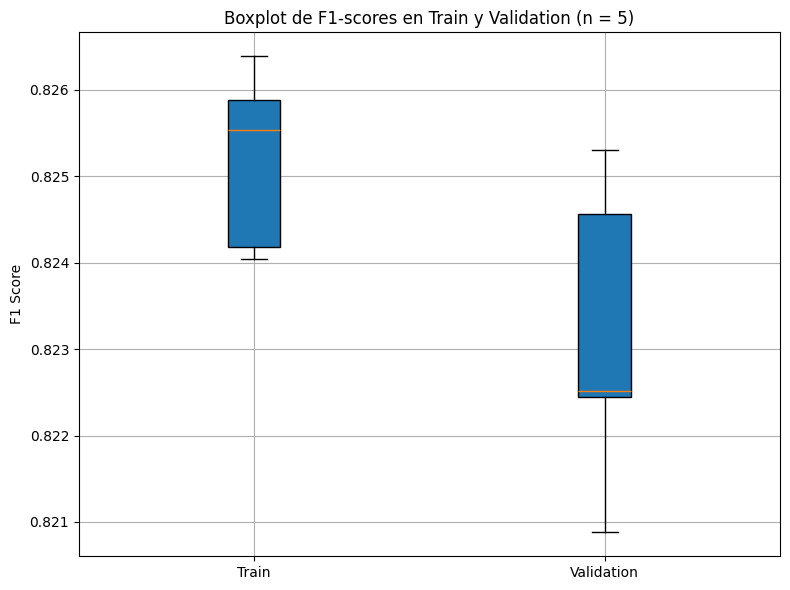

In [71]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt

# Number of partitions
n_particiones = 5

# Lists to store F1 scores
f1_train_scores = []
f1_val_scores = []

# Repeat the process n_particiones times
for i in range(n_particiones):
    # Create different train/validation splits
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, stratify=y_trainval, test_size=0.2, random_state=i
    )

    # Initialize and train the Gradient Boosting Classifier
    clf = GradientBoostingClassifier(random_state=42)
    clf.fit(X_train, y_train)

    # Predict and evaluate on train set
    y_train_pred = clf.predict(X_train)
    f1_train = f1_score(y_train, y_train_pred, average='binary')
    f1_train_scores.append(f1_train)

    # Predict and evaluate on validation set
    y_val_pred = clf.predict(X_val)
    f1_val = f1_score(y_val, y_val_pred, average='binary')
    f1_val_scores.append(f1_val)

    # Print F1 scores
    print(f"Iteration {i + 1}: F1-score (Train) = {f1_train:.4f}, F1-score (Validation) = {f1_val:.4f}")

# Mean F1 scores
f1_train_promedio = np.mean(f1_train_scores)
f1_val_promedio = np.mean(f1_val_scores)

print(f"\nMean F1 in Train: {f1_train_promedio:.4f}")
print(f"Mean F1 in Validation: {f1_val_promedio:.4f}")

# Boxplot for F1 scores
plt.figure(figsize=(8, 6))
plt.boxplot([f1_train_scores, f1_val_scores], labels=['Train', 'Validation'], patch_artist=True)
plt.title('Boxplot de F1-scores en Train y Validation (n = {})'.format(n_particiones))
plt.ylabel('F1 Score')
plt.grid(True)
plt.tight_layout()
plt.show()


Hyperparameter tunning for gradient boosting

In [72]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import f1_score
from scipy.stats import randint, uniform
import numpy as np

# Setup
n_splits = 5
f1_comparisons = []
best_params_list = []
model_list = []

# Gradient Boosting hyperparameter search space
param_dist = {
    'n_estimators': randint(100, 500),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'subsample': uniform(0.6, 0.4),  # from 0.6 to 1.0
    'max_features': ['sqrt', 'log2', None]
}

# Iterate over manual splits
for i in range(n_splits):
    print(f"\n--- Split {i+1} ---")

    # Split
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval,
        stratify=y_trainval,
        test_size=0.2,
        random_state=i
    )

    # Base model
    modelo_a_optimizar = GradientBoostingClassifier(random_state=42)

    # Randomized SearchCV
    search = RandomizedSearchCV(
        modelo_a_optimizar,
        param_distributions=param_dist,
        n_iter=10,
        cv=5,
        scoring='f1',
        n_jobs=-1,
        verbose=2,
        random_state=42
    )

    # Fit search
    search.fit(X_train, y_train)
    best_params = search.best_params_
    best_params_list.append(best_params)

    # Train model with best hyperparameters
    best_gb = GradientBoostingClassifier(
        **best_params,
        random_state=42
    )
    best_gb.fit(X_train, y_train)
    model_list.append(best_gb)

    # Evaluate
    y_pred_val = best_gb.predict(X_val)
    f1 = np.round(f1_score(y_val, y_pred_val), 4)

    f1_comparisons.append({
        'Split': i + 1,
        'F1 Score': f1,
        'Best Params': best_params
    })

# Summary
print("\nBest hyperparameters for each split:")
for entry in f1_comparisons:
    print(f"Split {entry['Split']}: F1 = {entry['F1 Score']}, Params = {entry['Best Params']}")



--- Split 1 ---
Fitting 5 folds for each of 10 candidates, totalling 50 fits

--- Split 2 ---
Fitting 5 folds for each of 10 candidates, totalling 50 fits

--- Split 3 ---
Fitting 5 folds for each of 10 candidates, totalling 50 fits

--- Split 4 ---
Fitting 5 folds for each of 10 candidates, totalling 50 fits

--- Split 5 ---
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best hyperparameters for each split:
Split 1: F1 = 0.8224, Params = {'learning_rate': 0.13958350559263474, 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 13, 'n_estimators': 154, 'subsample': 0.9932923543227152}
Split 2: F1 = 0.8214, Params = {'learning_rate': 0.13958350559263474, 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 13, 'n_estimators': 154, 'subsample': 0.9932923543227152}
Split 3: F1 = 0.8229, Params = {'learning_rate': 0.13958350559263474, 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 

All split returned the same hyperparameters:

best_gd_params = {'learning_rate': 0.13958350559263474, 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 13, 'n_estimators': 154, 'subsample': 0.9932923543227152}

### Lets train each model with each best hyperparameters with the whole development dataset and predict on test

In [73]:
log_model=LogisticRegression(max_iter=1000,
    C=0.01,
    penalty='elasticnet',
    l1_ratio=0.75,
    solver='saga',
    random_state=42)

decision_tree_model = DecisionTreeClassifier(
    ccp_alpha= 0.0006976409181650647, 
    criterion= 'entropy',
    max_features= 5,
    min_samples_leaf= 1,
    min_samples_split= 20,
    max_depth= 9,
    random_state=42)

rf_model=RandomForestClassifier(
    bootstrap= False,
    criterion= "entropy",
    max_depth= 10,
    max_features= 'log2',
    min_samples_leaf= 4,
    min_samples_split= 19,
    n_jobs=-1,
    random_state=42)

gb_model = GradientBoostingClassifier(
    learning_rate= 0.13958350559263474,
    max_depth= 3,
    max_features= None,
    min_samples_leaf= 3,
    min_samples_split= 13,
    n_estimators= 154,
    subsample= 0.9932923543227152,
    random_state=42)

Generate X and y_test

In [74]:
X_test = test_sample.drop(columns=['label'])
y_test = test_sample['label']

In [75]:
#Train LogRegression separate because it needs scalation

model_name = log_model.__class__.__name__

# Dictionary to store F1 scores
f1_results = {}

#Scale (only necesary in logReg)
scaler = StandardScaler()

# Scale data of devolopment and test
X_trainval_scaled = scaler.fit_transform(X_trainval)
X_test_scaled = scaler.transform(X_test)

# Traind model with devolpment data
log_model.fit(X_trainval_scaled, y_trainval)

# Predict
y_trainval_pred = log_model.predict(X_trainval_scaled)
y_test_pred = log_model.predict(X_test_scaled)

# Calculate f1 score
f1_dev = f1_score(y_trainval, y_trainval_pred)
f1_test = f1_score(y_test, y_test_pred)

# Store results
f1_results[model_name] = {
    'F1_Development': f1_dev,
    'F1_Test': f1_test}

    # Print results
print(f"{model_name} F1 in Development: {f1_dev:.4f}")
print(f"{model_name} F1 in Test: {f1_test:.4f}")

LogisticRegression F1 in Development: 0.8238
LogisticRegression F1 in Test: 0.8261


In [76]:
#Train the rest of the models

model_list=[decision_tree_model, rf_model, gb_model]

# Loop through models
for model in model_list:
    model_name = model.__class__.__name__ 

    # Train
    model.fit(X_trainval, y_trainval)

    # Predict
    y_trainval_pred = model.predict(X_trainval)
    y_test_pred = model.predict(X_test)

    # Calculate F1 scores
    f1_train = f1_score(y_trainval, y_trainval_pred)
    f1_test = f1_score(y_test, y_test_pred)

    # Store results
    f1_results[model_name] = {
        'F1_Development': f1_train,
        'F1_Test': f1_test
    }

# Print results
for model_name, scores in f1_results.items():
    print(f"Model: {model_name}")
    print(f"  F1 Development: {scores['F1_Development']:.4f}")
    print(f"  F1 Test:        {scores['F1_Test']:.4f}")
    print()


Model: LogisticRegression
  F1 Development: 0.8238
  F1 Test:        0.8261

Model: DecisionTreeClassifier
  F1 Development: 0.8172
  F1 Test:        0.8216

Model: RandomForestClassifier
  F1 Development: 0.8282
  F1 Test:        0.8241

Model: GradientBoostingClassifier
  F1 Development: 0.8261
  F1 Test:        0.8253



Interestingly the wasn´t and improvement from our baseline logistic regression model.

This could be the dataset is not too big and with little interaction. Lets explore the variable importance


Model: LogisticRegression
               Feature  Coefficient
0    mean_calification     0.741579
3   is_favorite_author     0.186660
2   is_favorite_gender     0.088714
1           nacimiento    -0.062465
13   vive_en_Venezuela     0.053982
9      vive_en_Ecuador     0.025497
11        vive_en_Peru     0.019087
10      vive_en_España    -0.006437
5           sexo_Mujer    -0.002324
4          sexo_Hombre     0.002324
6      vive_en_Andorra     0.000000
7    vive_en_Argentina     0.000000
8        vive_en_Chile     0.000000
12          vive_en_UK     0.000000


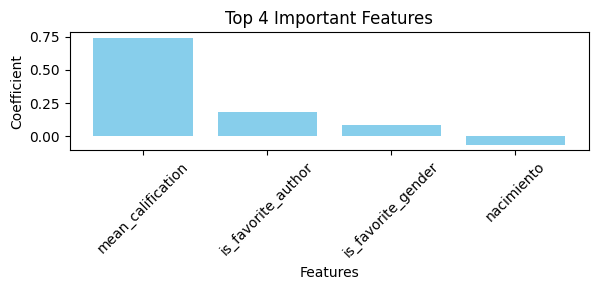


Model: DecisionTreeClassifier
               Feature  Importance
0    mean_calification    0.943984
1           nacimiento    0.029710
3   is_favorite_author    0.014077
2   is_favorite_gender    0.010689
13   vive_en_Venezuela    0.001072
9      vive_en_Ecuador    0.000469
4          sexo_Hombre    0.000000
5           sexo_Mujer    0.000000
6      vive_en_Andorra    0.000000
7    vive_en_Argentina    0.000000
8        vive_en_Chile    0.000000
10      vive_en_España    0.000000
11        vive_en_Peru    0.000000
12          vive_en_UK    0.000000


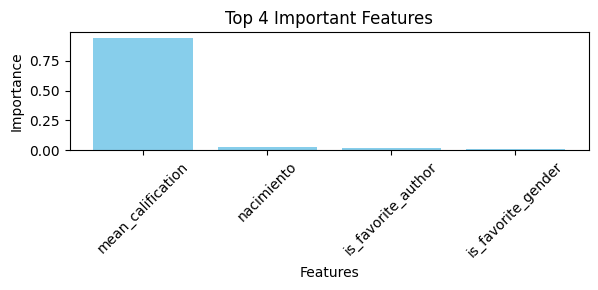


Model: RandomForestClassifier
               Feature  Importance
0    mean_calification    0.820591
1           nacimiento    0.115326
3   is_favorite_author    0.032811
2   is_favorite_gender    0.013058
4          sexo_Hombre    0.003280
13   vive_en_Venezuela    0.003190
5           sexo_Mujer    0.003056
10      vive_en_España    0.003032
7    vive_en_Argentina    0.001691
8        vive_en_Chile    0.001429
9      vive_en_Ecuador    0.000855
11        vive_en_Peru    0.000652
6      vive_en_Andorra    0.000607
12          vive_en_UK    0.000420


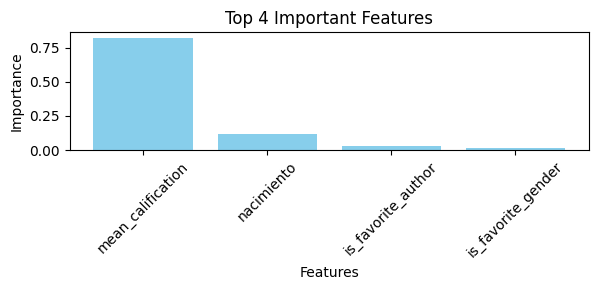


Model: GradientBoostingClassifier
               Feature  Importance
0    mean_calification    0.805398
1           nacimiento    0.142005
3   is_favorite_author    0.023018
2   is_favorite_gender    0.009412
5           sexo_Mujer    0.006225
4          sexo_Hombre    0.004146
10      vive_en_España    0.003894
7    vive_en_Argentina    0.001660
13   vive_en_Venezuela    0.001263
8        vive_en_Chile    0.000965
9      vive_en_Ecuador    0.000855
12          vive_en_UK    0.000669
11        vive_en_Peru    0.000283
6      vive_en_Andorra    0.000209


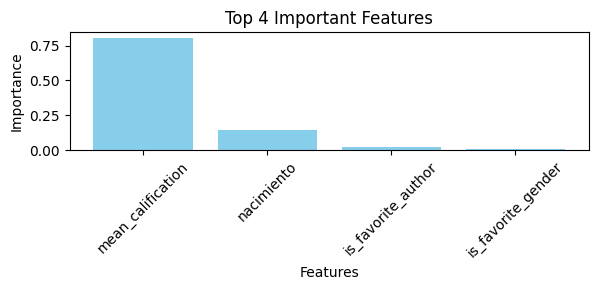

In [112]:
import pandas as pd

model_list=[log_model, decision_tree_model, rf_model, gb_model]

# Assuming your features are in X_trainval as a DataFrame:
feature_names = X_trainval.columns if hasattr(X_trainval, 'columns') else [f'feat_{i}' for i in range(X_trainval.shape[1])]

for model in model_list:
    model_name = model.__class__.__name__
    print(f"\nModel: {model_name}")

    if model_name == 'LogisticRegression':
        # Coefficients
        coefs = model.coef_[0]  # for binary classification
        coef_df = pd.DataFrame({
            'Feature': feature_names,
            'Coefficient': coefs
        }).sort_values(by='Coefficient', key=abs, ascending=False)
        print(coef_df)

        top4=coef_df.iloc[:4]
        plt.figure(figsize=(6,3))
        plt.bar(top4["Feature"], top4["Coefficient"], color="skyblue")
        plt.xlabel("Features")
        plt.ylabel("Coefficient")
        plt.title("Top 4 Important Features")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    elif model_name in ['DecisionTreeClassifier', 'RandomForestClassifier', 'GradientBoostingClassifier']:
        # Feature importances
        importances = model.feature_importances_
        imp_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)
        print(imp_df)

        top4=imp_df.iloc[:4]
        plt.figure(figsize=(6,3))
        plt.bar(top4["Feature"], top4["Importance"], color="skyblue")
        plt.xlabel("Features")
        plt.ylabel("Importance")
        plt.title("Top 4 Important Features")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    else:
        print("No coefficients or importances available for this model.")


We can see that the mean calification is the most importan variable for each model! The added variables related to see if the book has the reader´s favourite gender or author have little importance and the demographic variables don´t apport much, meaning they can be discarded

This tell us that a global metric such as the mean calification is the most important when developing an introductory recomendation system!